In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Train 1

**Code mô phỏng được viết và chạy trược tiếp trên Google Colab giống như Jupyter Notebook**

 - Google colab cho phép chúng ta sử dụng GPU Tesla K80 của Google để train và test thay vì phải dùng máy tính, laptop cá nhân.
 - Để có thể sử dụng GPU của google, người dùng vào Runtime -> Change runtime type -> Hardware accelerator -> chọn GPU

**Hướng dẫn download các thư viện không có sẵn trên GPU của google**
- GPU của google đã được cài đặt sẵn một số thư viện cho người dùng.
- Khi import 1 thư viện có lỗi thì thư viện đó chưa có săn trên GPU và cần được download
- Để download 1 thư viện mới chùng ta dùng lệnh: '!pip install 'tên thư viện''

In [ ]:
!pip install pydicom                     #download và cài đặt tv dicom để đọc ảnh DICOM

**Tiếp theo sẽ là phần cài đặt và import các thư viện cần thiết cho việc lập trình**

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
import pydicom, cv2, re, sys
import os, fnmatch, shutil, subprocess
from IPython.utils import io
import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

- **Các file có chứa Contours và ảnh DICOM tập train, test, validation của bộ dữ liệu Sunny Brook đã được upload lên drive của cá nhân**

![alt text](https://drive.google.com/uc?id=1xU-M_2OMAox8875FZFDpLVCWD255TYpk)

- **Chúng ta cần tạo một PyDrive client để có thể kết nối Colab với Google Drive và download các file về phần Files của Colab:**
![picture](https://drive.google.com/uc?id=1tF2T0TGX8nw4UAr6An4i4ZlVF9oP875i)


In [ ]:
#code này có tác dụng xác thực và tạo một PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#copy link các file chứa Contours và ảnh DICOM trên google drive để lấy id của file

link1 = 'https://drive.google.com/open?id=1syNHm52OxhDLpVAxDlaUwbG__uPPV9nB'
fluff1, id1 = link1.split('=')
link2 = 'https://drive.google.com/open?id=1elkebTeOt0Qy-YqqN_6wJVqqS7mz7ijU'
fluff2, id2 = link2.split('=')
link3 = 'https://drive.google.com/open?id=1o_OTO3G8UB2CCc94cBl3JJ_38SU_gB55'
fluff3, id3 = link3.split('=')
link4 = 'https://drive.google.com/open?id=1XyXsVAKBD-w1sOkuQQ1OaYzvC9GW5Anr'
fluff4, id4 = link4.split('=')
link5 = 'https://drive.google.com/open?id=1HiRfF0YtA4SlmaOj8T1EBVZ-rPRHqv1d'
fluff5, id5 = link5.split('=')
link6 = 'https://drive.google.com/open?id=16k8c1nL_Z3bi9FM--kN69AW0lsnKj-vT'
fluff6, id6 = link6.split('=')

In [ ]:
# Tải cái file đã có id từ google drive về Files của google colab

f1 = drive.CreateFile({'id': id1})
f1.GetContentFile('DICOMPart3.zip')
f2 = drive.CreateFile({'id': id2})
f2.GetContentFile('ContoursPart3.zip')
f3 = drive.CreateFile({'id': id3})
f3.GetContentFile('DICOMPart1.zip')
f4 = drive.CreateFile({'id': id4})
f4.GetContentFile('ContoursPart1.zip')
f5 = drive.CreateFile({'id': id5})
f5.GetContentFile('DICOMPart2.zip')
f6 = drive.CreateFile({'id': id6})
f6.GetContentFile('ContoursPart2.zip')

**Các file sau khi tải về thư mục Files:**

![alt text](https://drive.google.com/uc?id=1c1mTuPQpwj0OZ7p1ZOkwm7N0FNDFtFgr)

**Các file được lưu vào colab là file zip do đó chúng ta cần tạo thư mục và giải nén các file vào thư mục đó**

In [ ]:
import os
SUNNYBROOK_ROOT_PATH = "extract"            #tên thư mục chứa các file sau khi giải nén

# Tạo các đường dẫn cần thiết để truy cập lấy ảnh DICOM và Contours của tập train, test, validation
TRAIN_CONTOUR_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,
                            "Sunnybrook Cardiac MR Database ContoursPart3",
                            "TrainingDataContours")
TRAIN_IMG_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,
                        "Sunnybrook Cardiac MR Database DICOMPart3",
                        "TrainingDataDICOM")
TEST_CONTOUR_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,
                            "Sunnybrook Cardiac MR Database ContoursPart1",
                            "OnlineDataContours")
TEST_IMG_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,
                        "Sunnybrook Cardiac MR Database DICOMPart1",
                        "OnlineDataDICOM")
VAL_CONTOUR_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,
                            "Sunnybrook Cardiac MR Database ContoursPart2",
                            "ValidationDataContours")
VAL_IMG_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,
                        "Sunnybrook Cardiac MR Database DICOMPart2",
                        "ValidationDataDICOM")

In [ ]:
from zipfile import ZipFile

#giải nén các file zip vào thư mục 'extract'

with ZipFile('DICOMPart3.zip', 'r') as zipObj:
   # Extract all the contents of zip file in different directory
   zipObj.extractall(SUNNYBROOK_ROOT_PATH)
with ZipFile('ContoursPart3.zip', 'r') as zipObj:
   # Extract all the contents of zip file in different directory
   zipObj.extractall(SUNNYBROOK_ROOT_PATH)
with ZipFile('DICOMPart1.zip', 'r') as zipObj:
   # Extract all the contents of zip file in different directory
   zipObj.extractall(SUNNYBROOK_ROOT_PATH)
with ZipFile('ContoursPart1.zip', 'r') as zipObj:
   # Extract all the contents of zip file in different directory
   zipObj.extractall(SUNNYBROOK_ROOT_PATH)
with ZipFile('DICOMPart2.zip', 'r') as zipObj:
   # Extract all the contents of zip file in different directory
   zipObj.extractall(SUNNYBROOK_ROOT_PATH)
with ZipFile('ContoursPart2.zip', 'r') as zipObj:
   # Extract all the contents of zip file in different directory
   zipObj.extractall(SUNNYBROOK_ROOT_PATH)

**Thư mục Files sau khi giải nén các file zip:**

![alt text](https://drive.google.com/uc?id=1uTv4h-o8FRgm6hqpoiQMv3YiBThbPZDb)

**Tạo class Contour với tham số là đường dẫn của các contours, có các thuộc tính:**

- ctr_path: đường dẫn đầy đủ của contours.  
    VD:extract/Sunnybrook Cardiac MR Database ContoursPart1/OnlineDataContours/SC-HF-I-09/contours-manual/IRCCI-expert/IM-0001-0007-icontour-manual.txt

- case: tên các thư mục con khác nhau, mỗi thư mục con lại chứa các contour khác nhau.  
    VD: SC-HF-I-09

- img_no: số thứ tự của contours được vẽ tay tương ứng với ảnh DICOM.  
    VD: tên file contour là: 'IM-0001-0007-icontour-manual.txt' mã tương ứng là 0007.

In [ ]:
class Contour(object):
    def __init__(self, ctr_path):
        self.ctr_path = ctr_path
        match = re.search(r"(.*)DataContours/([^/]*)/contours-manual/IRCCI-expert/IM-0001-(\d{4})-icontour-manual.txt", ctr_path)
        
        self.case = match.group(2)
        self.img_no = int(match.group(3))
    
    def __str__(self):
        return "<Contour for image %d>" % (self.img_no)
    
    __repr__ = __str__


**Hàm load_contour(contour, im_path):**

- contour: đối tượng của class Contour

- im_path: phần đầu của đường dẫn tới các ảnh DICOM, chính là các đường dẫn TRAIN_IMG_PATH/TEST_IMG_PATH/VAL_IMG_PATH đã tạo ở trên.

- hàm sẽ lấy các thuộc tính case và img_no của đối tượng contour ghép thành đường dẫn hoàn chỉnh để lấy ảnh DICOM tương ứng với contour, đồng thời tạo label - ảnh nhãn phân vùng tâm thất trái - từ ảnh DICOM và contour. Hàm trả về ảnh DICOM và label tương ứng.

In [ ]:
def load_contour(contour, img_path):
    filename = "IM-0001-%04d.dcm" % (int(contour.img_no))
    full_path = os.path.join(img_path, contour.case, "DICOM", filename)
    f = pydicom.read_file(full_path)
    img = f.pixel_array.astype(np.int)
    ctrs = np.loadtxt(contour.ctr_path, delimiter=" ").astype(np.int)
    label = np.zeros_like(img, dtype="uint8")
    cv2.fillPoly(label, [ctrs], 1)
    return img, label


**Hàm get_all_contours(contour_path):**

- contour_path: các đường dẫn TRAIN_CONTOUR_PATH/TEST_CONTOUR_PATH/VAL_CONTOUR_PATH đã tạo ở trên

- Trả về list các đối tượng Contour là tất cả các đường dẫn của các contour trong 'contour_path' đầu vào 

In [ ]:
def get_all_contours(contour_path):
    contours = [os.path.join(dirpath, f)
        for dirpath, dirnames, files in os.walk(contour_path)
        for f in fnmatch.filter(files, 'IM-0001-*-icontour-manual.txt')]
    print("Shuffle data")
    np.random.shuffle(contours)
    print("Number of examples: {:d}".format(len(contours)))
    extracted = map(Contour, contours)
    return list(extracted)

**------Hàm trả về ảnh đã được crop chính giữa 100x100------**

In [ ]:
def center_crop(img, crop_size = (128,128)):
  w_in, h_in = img.shape
  w_out, h_out = crop_size
  img_clone = np.zeros((w_out, h_out, 1)) #1
  sub_w = int((w_in - w_out)/2)
  sub_h = int((h_in - h_out)/2)
  img_clone[:,:,0] = img[sub_w:sub_w+w_out, sub_h:sub_h+h_out]
  return img_clone

**Hàm extract_all_contours(contour, crop_size, string):**
- contour: 1 list các đối tượng Contour

- crop_size: kích thước của ảnh cắt

- string: các đường dẫn TRAIN_IMG_PATH/TEST_IMG_PATH/VAL_IMG_PATH

- hàm trả về mảng (numpy_array) các tất cả các ảnh DICOM có trong các file và các label tương ứng của nó (x, y)

In [ ]:
def extract_all_contours(contour, crop_size, string):
  w,h = crop_size
  img_list = np.zeros((len(contour), w, h, 3)) #1
  mask_list = np.zeros((len(contour), w, h, 1))
  for i, part in enumerate(contour):
    img, mask = load_contour(part, string)
    if i%40 == 0:
      plt.imshow(img)
      plt.show()
      plt.imshow(mask)
      plt.show()
    img_list[i] = center_crop(img, crop_size)
    mask_list[i] = center_crop(mask, crop_size)
  return img_list, mask_list

**Lấy các list chứa đường dẫn contour của tập train, test và validation**

In [ ]:
train = get_all_contours(TRAIN_CONTOUR_PATH)
test = get_all_contours(TEST_CONTOUR_PATH)
val = get_all_contours(VAL_CONTOUR_PATH)

Shuffle data
Number of examples: 260
Shuffle data
Number of examples: 279
Shuffle data
Number of examples: 266


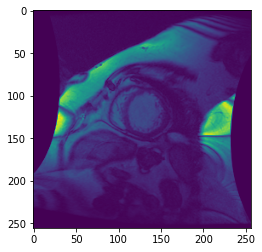

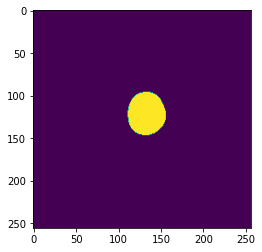

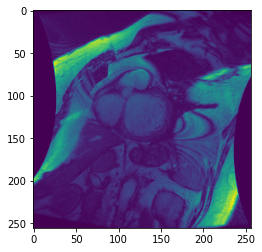

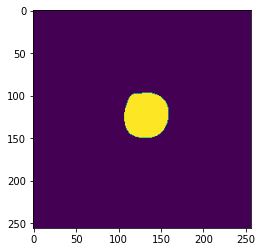

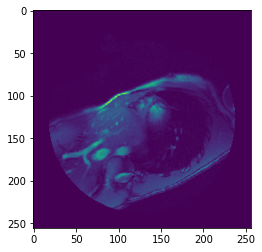

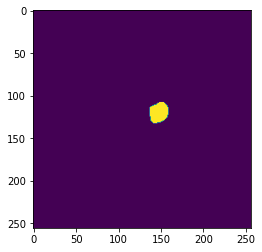

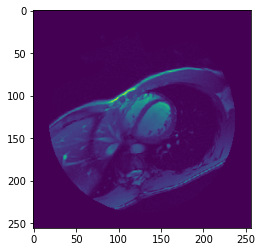

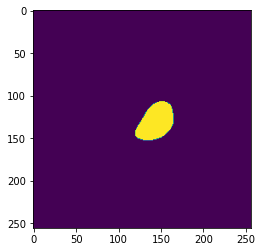

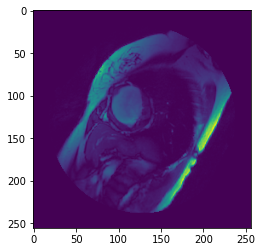

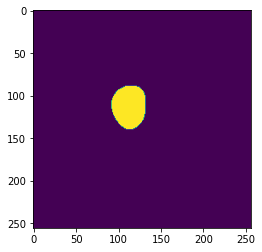

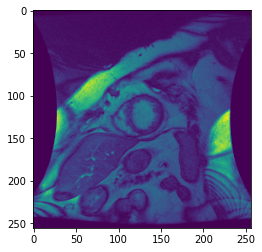

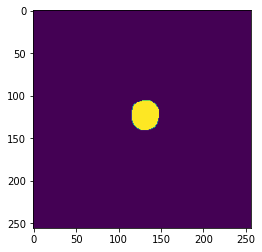

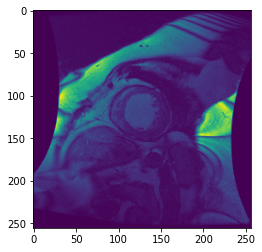

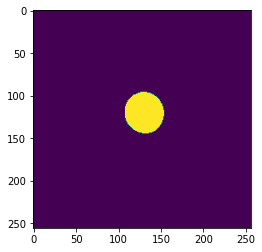

In [ ]:
TRAIN_IMG_PATH
crop_size = (128,128)
# x_train, y_train = extract_all_contours(train, crop_size, TRAIN_IMG_PATH)
x_test, y_test = extract_all_contours(test, crop_size, TEST_IMG_PATH)

**Trả về x_train, y_train là img_list, mask_list của ảnh DICOM và contours đã khớp nhau**

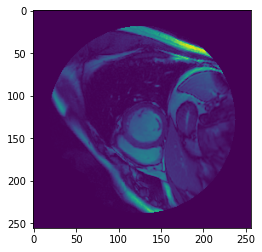

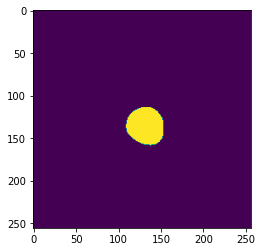

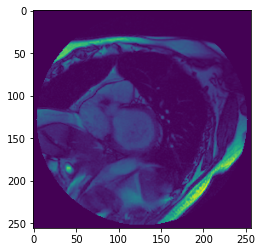

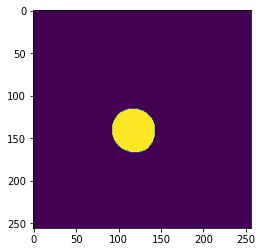

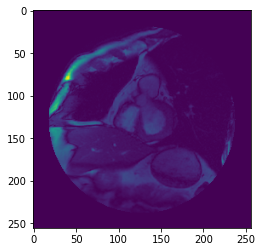

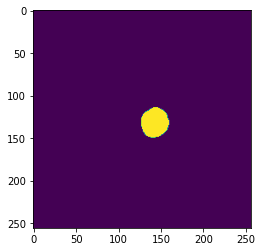

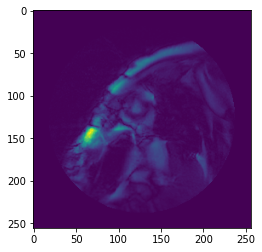

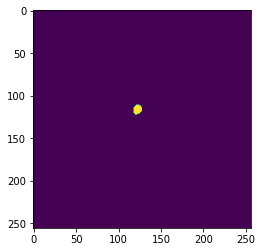

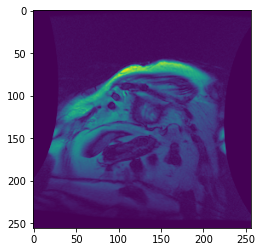

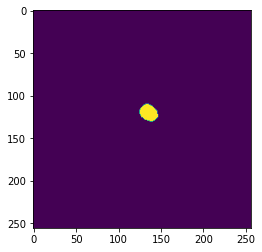

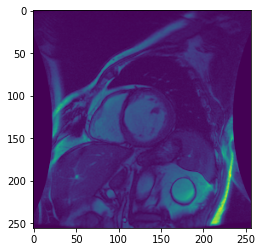

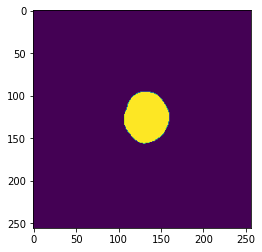

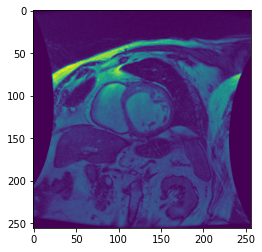

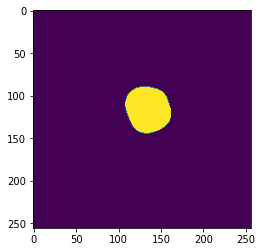

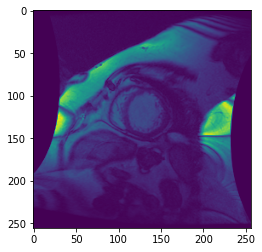

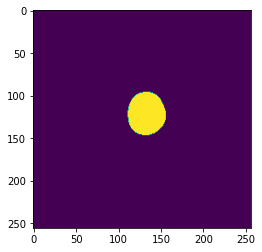

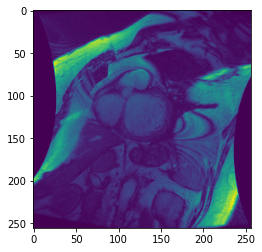

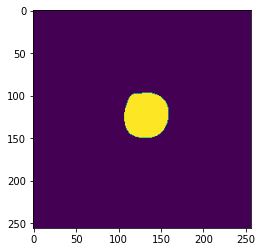

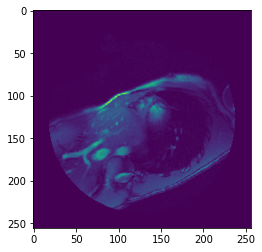

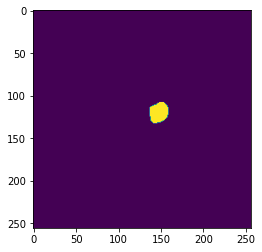

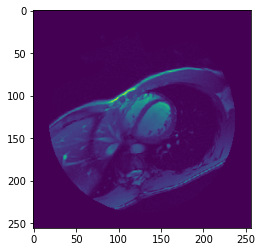

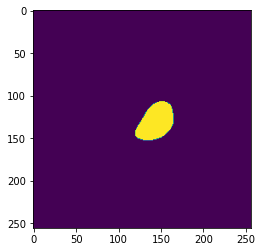

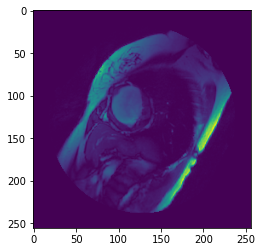

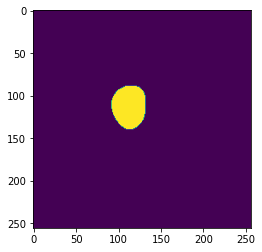

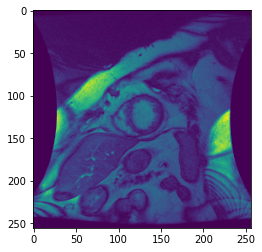

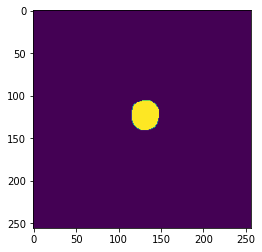

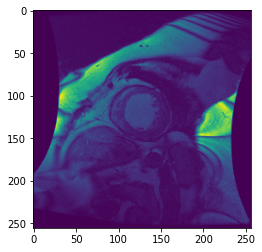

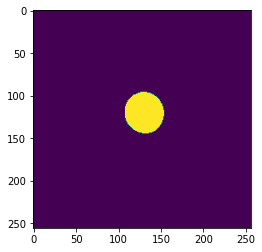

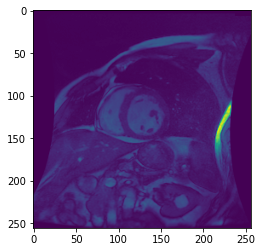

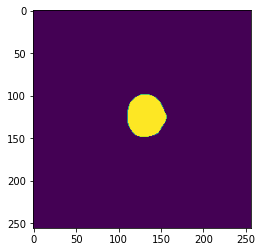

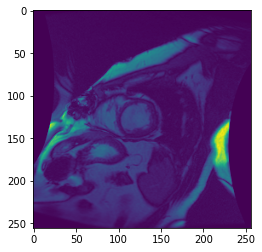

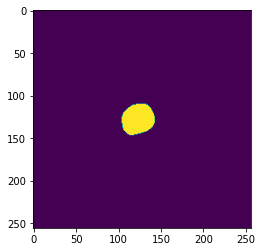

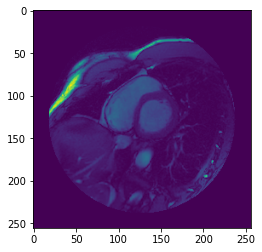

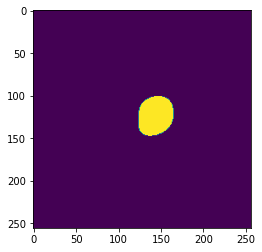

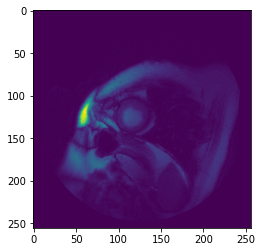

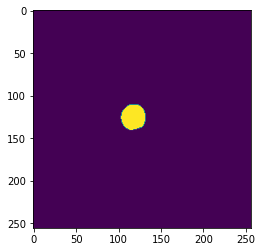

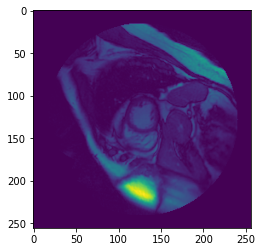

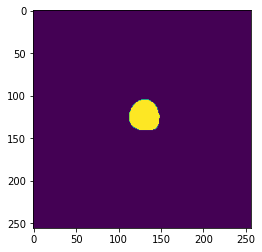

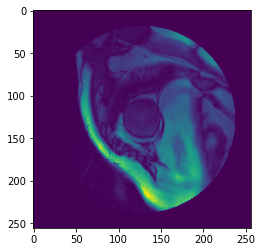

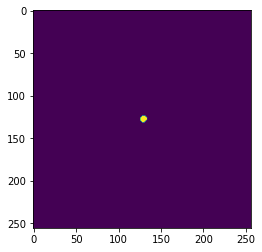

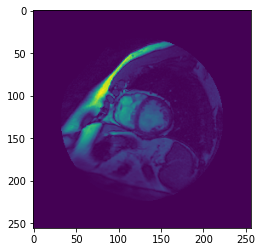

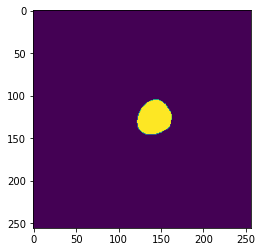

In [ ]:
crop_size = (128,128)
x_train, y_train = extract_all_contours(train, crop_size, TRAIN_IMG_PATH)
x_test, y_test = extract_all_contours(test, crop_size, TEST_IMG_PATH)
x_val, y_val = extract_all_contours(val, crop_size, VAL_IMG_PATH)

x_test = np.concatenate((x_test, x_val), axis = 0)
y_test = np.concatenate((y_test, y_val), axis = 0)

In [ ]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(260, 128, 128, 3)
(260, 128, 128, 1)
(545, 128, 128, 3)
(545, 128, 128, 1)


In [ ]:
'''np.save('/content/drive/MyDrive/brain_mri_segmentation/dataset/cardiac_mri_sun09/x_train_crop_128_endo_sun09.npy', x_train)
np.save('/content/drive/MyDrive/brain_mri_segmentation/dataset/cardiac_mri_sun09/y_train_crop_128_endo_sun09.npy', y_train)

np.save('/content/drive/MyDrive/brain_mri_segmentation/dataset/cardiac_mri_sun09/x_test_crop_128_endo_sun09.npy', x_test)
np.save('/content/drive/MyDrive/brain_mri_segmentation/dataset/cardiac_mri_sun09/y_test_crop_128_endo_sun09.npy', y_test)'''

# Train 2

In [ ]:
#import các thư viện của keras để xây dựng và traing cho model fcn
import numpy as np
from keras.models import *
from tensorflow.keras.optimizers import SGD, Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import backend as K
from keras.layers import *
from tensorflow.python.keras.layers import Layer
from keras.layers import Activation,BatchNormalization,Conv2D,Lambda, add, average, Input, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

Định nghĩa hàm ImageDataGenerator :

horizontal_flip=True : ngẫu nhiên lật theo chiều ngang

vertical_flip=True : ngẫu nhiên lật theo chiều dọc

rotation_range : lật 180 độ

In [ ]:
generator_x = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 180
)
generator_y = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 180
)

In [ ]:
seed = 1234
batch = 1
x_gen = generator_x.flow(x_train, batch_size = batch, shuffle = False, seed = seed)
y_gen = generator_y.flow(y_train, batch_size = batch, shuffle = False, seed = seed)
train_generator = zip(x_gen, y_gen)


-------------------FCN Model-------------------

In [ ]:
# hàm 'mvn' nhận đầu vào là 1 mang nhiều chiều và trả về 1 mảng có số chiều tương tự có kỳ vọng bằng 0 và phương sai bằng 1
def mvn(tensor):
    '''Performs per-channel spatial mean-variance normalization.'''
    epsilon = 1e-6
    mean = K.mean(tensor, axis=(1,2), keepdims=True)
    std = K.std(tensor, axis=(1,2), keepdims=True)
    mvn = (tensor - mean) / (std + epsilon)
    
    return mvn

# hàm 'crop' nhận đầu vào là list 2 mảng và đồng bộ kích thước của 2 mảng đó theo mảng có kích thước nhỏ hơn
def crop(tensors):
    '''
    List of 2 tensors, the second tensor having larger spatial dimensions.
    '''
    h_dims, w_dims = [], []
    for t in tensors:
        b, h, w, d = K.int_shape(t)
        h_dims.append(h)
        w_dims.append(w)
    crop_h, crop_w = (h_dims[1] - h_dims[0]), (w_dims[1] - w_dims[0])
    rem_h = int(crop_h % 2)
    rem_w = int(crop_w % 2)
    tt_h = int(crop_h / 2)
    tt_w = int(crop_w / 2)
    crop_h_dims = (tt_h, tt_h + rem_h)
    crop_w_dims = (tt_w, tt_w + rem_w)
    cropped = Cropping2D(cropping=(crop_h_dims, crop_w_dims))(tensors[1])
    
    return cropped

class Swish(tf.keras.layers.Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name, **kwargs)

    def call(self, inputs, **kwargs):
        return tf.nn.swish(inputs)

    def get_config(self):
        config = super().get_config()
        config['name'] = self.name
        return config

def squeeze_excite_block(reduce_ratio=0.25,name_block=None):
    def call(inputs):
        filters = inputs.shape[-1]
        num_reduced_filters= max(1, int(filters * reduce_ratio))
        se = Lambda(lambda a: K.mean(a, axis=[1,2], keepdims=True))(inputs)

        se = Conv2D(
                num_reduced_filters,
                kernel_size=[1, 1],
                strides=[1, 1],
                kernel_initializer='he_normal',
                padding='same',
                use_bias=True
            )(se)
        se = Swish()(se)
        se = Conv2D(
                filters,
                kernel_size=[1, 1],
                strides=[1, 1],
                kernel_initializer='he_normal',
                padding='same',
                use_bias=True
            )(se)
        se = Activation('sigmoid')(se)
        if name_block is not None:
          out = Multiply(name=name_block)([se, inputs])
        else : 
          out = Multiply()([se, inputs])
        return out
    return call

def refinement(y, filter):
    y = Conv2D(filter, 3,  padding="same")(y)
    y = Activation('swish')(y)
    y = Conv2D(1, 3,  padding="same")(y)
    y = Activation('sigmoid')(y)
    return y

def conv_block(filters,block_name=None): #kernel_size = (3,3), dilation = 1
  def call(inputs):
    x = inputs

    x = Conv2D(filters, kernel_size=(3,3), padding="same",dilation_rate =3, use_bias=False,kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Swish()(x)

    x = Conv2D(filters, kernel_size=(3,3), padding="same",dilation_rate =3, use_bias=False,kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Swish()(x)

    x = squeeze_excite_block(name_block=block_name)(x)

    return x
  return call

In [ ]:
def decoder_block(n_filter,skip=None):
  def call(inputs):
    x= Conv2DTranspose(n_filter, (2,2), strides=(2, 2), padding='same',kernel_initializer = 'he_normal')(inputs)
    out = x
    if skip is not None :
      attention = conv_block(n_filter)(skip)
      out = Concatenate()([x,attention])
    out = conv_block(n_filter)(out)

    return out
  return call
  
def dow_block(kernel_size=(2,2),stride=(2,2)):
  def call(inputs):
    out = MaxPooling2D(kernel_size, strides=stride)(inputs)
    return out
  return call

In [ ]:
def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same",use_bias=False,kernel_initializer='he_normal')(y1)
    y1 = BatchNormalization()(y1)
    y1 = Swish()(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)
    y1 = squeeze_excite_block()(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False,kernel_initializer='he_normal')(x)
    y2 = BatchNormalization()(y2)
    y2 = Swish()(y2)
    y2 = squeeze_excite_block()(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False,kernel_initializer='he_normal')(x)
    y3 = BatchNormalization()(y3)
    y3 = Swish()(y3)
    y3 = squeeze_excite_block()(y3)

    y4 = Conv2D(filter, 5, dilation_rate=12, padding="same", use_bias=False,kernel_initializer='he_normal')(x)
    y4 = BatchNormalization()(y4)
    y4 = Swish()(y4)
    y4 = squeeze_excite_block()(y4)

    y5 = Conv2D(filter, 7, dilation_rate=18, padding="same", use_bias=False,kernel_initializer='he_normal')(x)
    y5 = BatchNormalization()(y5)
    y5 = Swish()(y5)
    y5 = squeeze_excite_block()(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False,kernel_initializer='he_normal')(y)
    y = BatchNormalization()(y)
    y = Swish()(y)
    y = squeeze_excite_block()(y)
    return y

In [ ]:
def encoderSegnet(input_s=(128,128,1)):
  inp= Input(shape=input_s)
  o = inp
  nums_filter=[64,128,256,512,512]
  count=0
  for f in nums_filter[:-1]:
    count+=1
    o = conv_block(f,block_name='output_block_'+str(count))(o) #kernel=3,dilation = 3,
    o = dow_block()(o)

  o = conv_block(nums_filter[-1],block_name='output_block_'+str(count+1))(o)
  #o = Dropout(0.5)(o)
  return Model(inp,o)

list_skip = ["output_block_4", "output_block_3", "output_block_2", "output_block_1"]

In [ ]:
#Các hàm tính dice index, jaccard index và hàm dice_loss = 1 - dice index
def dice_coef(y_true, y_pred, smooth=0.0):
    '''Average dice coefficient per batch.'''
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    summation = K.sum(y_true + y_pred, axis=axes)
    
    return K.mean((2.0 * intersection + smooth) / (summation + smooth), axis=0)
    
def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred, 1.0)
    #return 1.0 - dice_coef(y_true, y_pred)
    
def jaccard_coef(y_true, y_pred, smooth=0.0):
    '''Average jaccard coefficient per batch.'''
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    union = K.sum(y_true + y_pred, axis=axes) - intersection
    return K.mean( (intersection + smooth) / (union + smooth), axis=0)

def TP(target, output, smooth=1e-10):
    target_positive = K.flatten(target)
    output_positive = K.flatten(output)
    true_pos = K.sum(target_positive * output_positive)

    return true_pos

def TN(target, output, smooth=1e-10):
    target_positive = K.flatten(target)
    output_positive = K.flatten(output)
    true_neg = K.sum((1-target_positive) * (1-output_positive))

    return true_neg

def FP(target, output, smooth=1e-10):
    target_positive = K.flatten(target)
    output_positive = K.flatten(output)
    false_pos = K.sum((1-target_positive) * output_positive)

    return false_pos

def FN(target, output, smooth=1e-10):
    target_positive = K.flatten(target)
    output_positive = K.flatten(output)
    false_neg = K.sum(target_positive * (1-output_positive))

    return false_neg

def sen(target, output, smooth=1e-10):
    target_positive = K.flatten(target)
    output_positive = K.flatten(output)

    true_pos = K.sum(target_positive * output_positive)
    true_neg = K.sum((1-target_positive) * (1-output_positive))
    false_neg = K.sum(target_positive * (1-output_positive))
    false_pos = K.sum((1-target_positive) * output_positive)

    sen = true_pos/(true_pos + false_neg)
    spe = true_neg/(true_neg + false_pos)
    return sen

def spe(target, output, smooth=1e-10):
    target_positive = K.flatten(target)
    output_positive = K.flatten(output)

    true_pos = K.sum(target_positive * output_positive)
    true_neg = K.sum((1-target_positive) * (1-output_positive))
    false_neg = K.sum(target_positive * (1-output_positive))
    false_pos = K.sum((1-target_positive) * output_positive)

    sen = true_pos/(true_pos + false_neg)
    spe = true_neg/(true_neg + false_pos)
    return spe

def accuracy(target, output, smooth=1e-10):
    target_positive = K.flatten(target)
    output_positive = K.flatten(output)

    true_pos = K.sum(target_positive * output_positive)
    true_neg = K.sum((1-target_positive) * (1-output_positive))
    false_neg = K.sum(target_positive * (1-output_positive))
    false_pos = K.sum((1-target_positive) * output_positive)

    p = (true_pos + true_neg + smooth)/(true_pos + true_neg + false_pos + false_neg + smooth)
    return p

In [ ]:
#hàm thực hiện learning rate decay
def lr_poly_decay(model, base_lr, curr_iter, max_iter, power=0.5):
    #lrate = 0.0001
    lrate = base_lr * (1.0 - (curr_iter / float(max_iter)))**power
    K.set_value(model.optimizer.lr, lrate)

    return K.eval(model.optimizer.lr)

**Hàm fcn_model xây dựng cấu trúc mạng neural của mô hình fcn**

![alt text](https://drive.google.com/uc?id=1wRnnPW5SIyUj9UbwsUB8_X98HMRMepPF)

In [ ]:
def fcn_model(input_shape, num_classes, weights=None):
    #binary-classification => sigmoid+dice_coef, multi => sofmax+crossentropy
    if num_classes == 2:
        num_classes = 1
        loss = dice_coef_loss #tversky_kahneman
        activation = 'sigmoid'
    else:
        loss = tversky_kahneman #'categorical_crossentropy'
        activation = 'softmax'
    #tạo layers của model fcn
    data = Input(shape=input_shape, dtype='float', name='data')
    mvn0 = Lambda(mvn)(data)
    pad0 = ZeroPadding2D(padding = 5)(mvn0)

    #conv0 = Conv2D(32, kernel_size = (1,1), padding = 'same', activation = 'relu',  use_bias = True)(pad0)
    #mvn0 = Lambda(mvn)(conv0)
    #mxp0 = MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'valid')(mvn0)

    conv1 = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'swish',  use_bias = True)(pad0) 
    mvn1 = Lambda(mvn)(conv1)

    conv2 = Conv2D(64,kernel_size = (1,3), padding = 'same', activation = 'swish',  use_bias =True)(mvn1)
    mvn2 = Lambda(mvn)(conv2)

    conv3 = Conv2D(64,kernel_size = (3,1), padding = 'same', activation = 'swish',  use_bias =True)(mvn2)
    mvn3 = Lambda(mvn)(conv3)

    conv_3 = Conv2D(64,kernel_size = (3,3), padding = 'same', dilation_rate=(1,1), activation = 'swish',  use_bias =True)(mvn3)
    mvn_3 = Lambda(mvn)(conv_3)

    mxp1 = MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'valid')(mvn_3)

    conv4 = Conv2D(128,kernel_size = (1,1), padding = 'same', activation = 'swish',  use_bias = True)(mxp1)
    mvn4 = Lambda(mvn)(conv4)

    conv5 = Conv2D(128,kernel_size = (1,5), padding = 'same', activation = 'swish',  use_bias = True)(mvn4)
    mvn5 = Lambda(mvn)(conv5)

    conv6 = Conv2D(128,kernel_size = (5,1), padding = 'same', activation = 'swish',  use_bias = True)(mvn5)
    mvn6 = Lambda(mvn)(conv6)

    conv7 = Conv2D(128,kernel_size = (3,3), padding = 'same', dilation_rate=(3,3), activation = 'swish',  use_bias = True)(mvn6)
    mvn7 = Lambda(mvn)(conv7)

    #drop1 = Dropout(rate = 0.5)(mvn7)

    mxp2 = MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'valid')(mvn7)

    conv8 = Conv2D(256,kernel_size = (1,1), padding = 'same', activation = 'swish',  use_bias = True)(mxp2)
    mvn8 = Lambda(mvn)(conv8)

    conv9 = Conv2D(256,kernel_size = (1,7), padding = 'same', activation = 'swish',  use_bias = True)(mvn8)
    mvn9 = Lambda(mvn)(conv9)

    conv10 = Conv2D(256,kernel_size = (7,1), padding = 'same', activation = 'swish',  use_bias = True)(mvn9)
    mvn10 = Lambda(mvn)(conv10)

    conv11 = Conv2D(256,kernel_size = (3,3), padding = 'same', dilation_rate=(5,5), activation = 'swish',  use_bias = True)(mvn10)
    mvn11 = Lambda(mvn)(conv11)

    mxp3 = MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'valid')(mvn11)
    
    drop2 = Dropout(rate = 0.5)(mxp3)

    conv12 = Conv2D(512,kernel_size = (1,1), padding = 'same', activation = 'swish',  use_bias = True)(drop2)
    mvn12 = Lambda(mvn)(conv12)

    conv13 = Conv2D(512,kernel_size = (1,9), padding = 'same', activation = 'swish',  use_bias = True)(mvn12)
    mvn13 = Lambda(mvn)(conv13)

    conv14 = Conv2D(512,kernel_size = (9,1), padding = 'same', activation = 'swish',  use_bias = True)(mvn13)
    mvn14 = Lambda(mvn)(conv14)

    conv15 = Conv2D(512,kernel_size = (3,3), padding = 'same', dilation_rate=(7,7), activation = 'swish',  use_bias = True)(mvn14)
    mvn15 = Lambda(mvn)(conv15)

    drop3 = Dropout(rate = 0.5)(mvn15)

    score_conv15 = Conv2D(1, (1,1), strides = (1,1), use_bias = True, padding = 'valid')(drop3)

    upsample1 = Conv2DTranspose(1, (3,3), strides = (2,2), use_bias = False, padding = 'valid')(score_conv15)
    #Conv2DTranspose = Deconvolution : phép biến đổi đi ngược lại tích chập 
    #từ một thứ có hình dạng đầu ra của 1 phép tích chập sang 1 thứ có hình dạng đầu vào của nó.
    score_conv11 = Conv2D(1, (1,1), strides = (1,1), use_bias = True, padding = 'valid')(mvn11)

    crop1 = Lambda(crop)([upsample1, score_conv11])
    fuse1 = average([crop1, upsample1])

    upsample2 = Conv2DTranspose(1, (3,3), strides = (2,2), use_bias = False, padding = 'valid')(fuse1)

    score_conv7 = Conv2D(1, (1,1), strides = (1,1), use_bias = True, padding = 'valid')(mvn7)

    crop2 = Lambda(crop)([upsample2, score_conv7])
    fuse2 = average([crop2, upsample2])

    upsample3 = Conv2DTranspose(1, (3,3), strides = (2,2), use_bias = False, padding = 'valid')(fuse2)

    crop3 = Lambda(crop)([data, upsample3])
    
    predict = Conv2D(1, (1,1), strides = (1,1), padding = 'valid', activation = 'sigmoid', use_bias = True)(crop3) 
    model = models.Model(inputs=data, outputs=predict)
    if weights is not None:
        model.load_weights(weights)
    nadam = tf.keras.optimizers.Nadam(0.001) #SGD(lr=0.01, momentum=0.9, nesterov=True)
    model.compile(optimizer=nadam, loss=loss,
                  metrics=[dice_coef, jaccard_coef])

    return model

In [ ]:
'''def fcn_model(input_shape, num_classes, weights=None):
    #binary-classification => sigmoid+dice_coef, multi => sofmax+crossentropy
    if num_classes == 2:
        num_classes = 1
        loss = dice_coef_loss
        activation = 'sigmoid'
    else:
        loss = 'categorical_crossentropy'
        activation = 'softmax'
    #tạo layers của model fcn
    data = Input(shape=input_shape, dtype='float', name='data')
    mvn0 = Lambda(mvn)(data)
    pad0 = ZeroPadding2D(padding = 5)(mvn0)

    conv1 = Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu',  use_bias = True)(pad0)
    mvn1 = Lambda(mvn)(conv1)

    conv2 = Conv2D(64,kernel_size = (3,3), padding = 'same', activation = 'relu',  use_bias =True)(mvn1)
    mvn2 = Lambda(mvn)(conv2)

    conv3 = Conv2D(64,kernel_size = (3,3), padding = 'same', activation = 'relu',  use_bias =True)(mvn2)
    mvn3 = Lambda(mvn)(conv3)

    mxp1 = MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'valid')(mvn3)

    conv4 = Conv2D(128,kernel_size = (3,3), padding = 'same', activation = 'relu',  use_bias = True)(mxp1)
    mvn4 = Lambda(mvn)(conv4)

    conv5 = Conv2D(128,kernel_size = (3,3), padding = 'same', activation = 'relu',  use_bias = True)(mvn4)
    mvn5 = Lambda(mvn)(conv5)

    conv6 = Conv2D(128,kernel_size = (3,3), padding = 'same', activation = 'relu',  use_bias = True)(mvn5)
    mvn6 = Lambda(mvn)(conv6)

    conv7 = Conv2D(128,kernel_size = (3,3), padding = 'same', activation = 'relu',  use_bias = True)(mvn6)
    mvn7 = Lambda(mvn)(conv7)

    #drop1 = Dropout(rate = 0.5)(mvn7)

    mxp2 = MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'valid')(mvn7)

    conv8 = Conv2D(256,kernel_size = (3,3), padding = 'same', activation = 'relu',  use_bias = True)(mxp2)
    mvn8 = Lambda(mvn)(conv8)

    conv9 = Conv2D(256,kernel_size = (3,3), padding = 'same', activation = 'relu',  use_bias = True)(mvn8)
    mvn9 = Lambda(mvn)(conv9)

    conv10 = Conv2D(256,kernel_size = (3,3), padding = 'same', activation = 'relu',  use_bias = True)(mvn9)
    mvn10 = Lambda(mvn)(conv10)

    conv11 = Conv2D(256,kernel_size = (3,3), padding = 'same', activation = 'relu',  use_bias = True)(mvn10)
    mvn11 = Lambda(mvn)(conv11)

    mxp3 = MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'valid')(mvn11)
    
    drop2 = Dropout(rate = 0.5)(mxp3)

    conv12 = Conv2D(512,kernel_size = (3,3), padding = 'same', activation = 'relu',  use_bias = True)(drop2)
    mvn12 = Lambda(mvn)(conv12)

    conv13 = Conv2D(512,kernel_size = (3,3), padding = 'same', activation = 'relu',  use_bias = True)(mvn12)
    mvn13 = Lambda(mvn)(conv13)

    conv14 = Conv2D(512,kernel_size = (3,3), padding = 'same', activation = 'relu',  use_bias = True)(mvn13)
    mvn14 = Lambda(mvn)(conv14)

    conv15 = Conv2D(512,kernel_size = (3,3), padding = 'same', activation = 'relu',  use_bias = True)(mvn14)
    mvn15 = Lambda(mvn)(conv15)

    drop3 = Dropout(rate = 0.5)(mvn15)

    score_conv15 = Conv2D(1, (1,1), strides = (1,1), use_bias = True, padding = 'valid')(drop3)

    upsample1 = Conv2DTranspose(1, (3,3), strides = (2,2), use_bias = False, padding = 'valid')(score_conv15)
    #Conv2DTranspose = Deconvolution : phép biến đổi đi ngược lại tích chập 
    #từ một thứ có hình dạng đầu ra của 1 phép tích chập sang 1 thứ có hình dạng đầu vào của nó.
    score_conv11 = Conv2D(1, (1,1), strides = (1,1), use_bias = True, padding = 'valid')(mvn11)

    crop1 = Lambda(crop)([upsample1, score_conv11])
    fuse1 = average([crop1, upsample1])

    upsample2 = Conv2DTranspose(1, (3,3), strides = (2,2), use_bias = False, padding = 'valid')(fuse1)

    score_conv7 = Conv2D(1, (1,1), strides = (1,1), use_bias = True, padding = 'valid')(mvn7)

    crop2 = Lambda(crop)([upsample2, score_conv7])
    fuse2 = average([crop2, upsample2])

    upsample3 = Conv2DTranspose(1, (3,3), strides = (2,2), use_bias = False, padding = 'valid' )(fuse2)

    crop3 = Lambda(crop)([data, upsample3])
    
    predict = Conv2D(1, (1,1), strides = (1,1), padding = 'valid', activation = 'sigmoid', use_bias = True)(crop3)
    model = models.Model(inputs=data, outputs=predict)
    if weights is not None:
        model.load_weights(weights)
    sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss=loss,
                  metrics=[dice_coef, jaccard_coef])

    return model'''

"def fcn_model(input_shape, num_classes, weights=None):\n    #binary-classification => sigmoid+dice_coef, multi => sofmax+crossentropy\n    if num_classes == 2:\n        num_classes = 1\n        loss = dice_coef_loss\n        activation = 'sigmoid'\n    else:\n        loss = 'categorical_crossentropy'\n        activation = 'softmax'\n    #tạo layers của model fcn\n    data = Input(shape=input_shape, dtype='float', name='data')\n    mvn0 = Lambda(mvn)(data)\n    pad0 = ZeroPadding2D(padding = 5)(mvn0)\n\n    conv1 = Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu',  use_bias = True)(pad0)\n    mvn1 = Lambda(mvn)(conv1)\n\n    conv2 = Conv2D(64,kernel_size = (3,3), padding = 'same', activation = 'relu',  use_bias =True)(mvn1)\n    mvn2 = Lambda(mvn)(conv2)\n\n    conv3 = Conv2D(64,kernel_size = (3,3), padding = 'same', activation = 'relu',  use_bias =True)(mvn2)\n    mvn3 = Lambda(mvn)(conv3)\n\n    mxp1 = MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'v

In [ ]:
'''def unet(input_shape, num_classes, weights=None):
  #binary-classification => sigmoid+dice_coef, multi => sofmax+crossentropy
  if num_classes == 2:
    num_classes = 1
    loss = dice_coef_loss
    activation = 'sigmoid'
  else:
    loss = 'categorical_crossentropy'
    activation = 'softmax'
  #tạo layers của model fcn
  data = Input(shape=input_shape, dtype='float', name='data')  
  s = BatchNormalization()(data)

  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
  c1 = BatchNormalization()(c1)
  c1 = Dropout(0.1) (c1)
  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
  c1 = BatchNormalization()(c1)
  p1 = MaxPooling2D((2, 2)) (c1)

  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
  c2 = BatchNormalization()(c2)
  c2 = Dropout(0.1) (c2)
  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
  c2 = BatchNormalization()(c2)
  p2 = MaxPooling2D((2, 2)) (c2)

  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
  c3 = BatchNormalization()(c3)
  c3 = Dropout(0.2) (c3)
  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
  c3 = BatchNormalization()(c3)
  p3 = MaxPooling2D((2, 2)) (c3)

  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
  c4 = BatchNormalization()(c4)
  c4 = Dropout(0.2) (c4)
  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
  s = BatchNormalization()(data)
  p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
  c5 = BatchNormalization()(c5)
  c5 = Dropout(0.3) (c5)
  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
  c5 = BatchNormalization()(c5)

  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
  c6 = BatchNormalization()(c6)
  c6 = Dropout(0.2) (c6)
  c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
  c6 = BatchNormalization()(c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
  c7 = BatchNormalization()(c7)
  c7 = Dropout(0.2) (c7)
  c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
  c7 = BatchNormalization()(c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
  c8 = BatchNormalization()(c8)
  c8 = Dropout(0.1) (c8)
  c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
  c8 = BatchNormalization()(c8)

  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
  c9 = BatchNormalization()(c9)
  c9 = Dropout(0.1) (c9)
  c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
  c9 = BatchNormalization()(c9)

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

  model = models.Model(inputs=data, outputs=outputs)
  if weights is not None:
    model.load_weights(weights)
  #sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
  model.compile(optimizer='adam', loss=loss, metrics=[dice_coef, jaccard_coef])

  return model'''

"def unet(input_shape, num_classes, weights=None):\n  #binary-classification => sigmoid+dice_coef, multi => sofmax+crossentropy\n  if num_classes == 2:\n    num_classes = 1\n    loss = dice_coef_loss\n    activation = 'sigmoid'\n  else:\n    loss = 'categorical_crossentropy'\n    activation = 'softmax'\n  #tạo layers của model fcn\n  data = Input(shape=input_shape, dtype='float', name='data')  \n  s = BatchNormalization()(data)\n\n  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)\n  c1 = BatchNormalization()(c1)\n  c1 = Dropout(0.1) (c1)\n  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)\n  c1 = BatchNormalization()(c1)\n  p1 = MaxPooling2D((2, 2)) (c1)\n\n  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)\n  c2 = BatchNormalization()(c2)\n  c2 = Dropout(0.1) (c2)\n  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', paddi

In [ ]:
from keras.layers import Input
#crop trước khi đưa vào model
crop_size = 128
num_classes = 2
input_shape = (crop_size,crop_size,1)

In [ ]:
model = fcn_model(input_shape,num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 1)  0           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 138, 138, 1)  0          ['lambda[0][0]']                 
                                                                                                  
 conv2d (Conv2D)                (None, 138, 138, 64  128         ['zero_padding2d[0][0]']     

**model FCN được trên trong 100 epochs các trọng số của mỗi iteration sẽ được lưu vào trong thư mục Files của colab. Sau khi train bộ weight có sai số dice_loss trên tập test thấp nhất sẽ được chọn.**

In [ ]:
epochs = 500
mini_batch_size = 1
test_loss = []
test_dice = []
train_loss = []
train_dice = []
max_iter = int((x_train.shape[0] / mini_batch_size)) * epochs
curr_iter = 0
base_lr = K.eval(model.optimizer.lr)
#lrate = lr_poly_decay(model, base_lr, curr_iter, max_iter, power=0.5)

for i in range(epochs):
  for iteration in range(x_train.shape[0]):
    x_batch, y_batch = next(train_generator)
    #print(x_batch.shape, y_batch.shape)
    model.train_on_batch(x_batch, y_batch)
    curr_iter += 1
    lrate = lr_poly_decay(model, base_lr, curr_iter,max_iter, power=0.5)
  print('epoch', i+1,':')
  loss1, dice1, jac1 = model.evaluate(x_test, y_test)
  loss2, dice2, jac2 = model.evaluate(x_train, y_train)
  print('test_loss: ', loss1,' dice_coef: ', dice1, ' jaccard_coef: ', jac1)
  print('train_loss: ', loss2,' dice_coef: ', dice2, ' jaccard_coef: ', jac2)
  train_dice.append(dice2)
  test_dice.append(dice1)
  train_loss.append(loss2)
  test_loss.append(loss1)
  print('saving weights ....')
  save_path = '_'.join(['sunnybrook','epoch','max']) + '.h5'
  if not os.path.exists('model_logs'):
    os.makedirs('model_logs')
  save_path = os.path.join('model_logs', save_path)
  model.save_weights(save_path)
  print('done')

epoch 1 :
5/5 [==============================] - 0s 83ms/step - loss: 0.0314 - dice_coef: 0.9670 - jaccard_coef: 0.9369
test_loss:  0.05713677033782005  dice_coef:  0.9428487420082092  jaccard_coef:  0.8970528841018677
train_loss:  0.03136714547872543  dice_coef:  0.9669572114944458  jaccard_coef:  0.9368698000907898
saving weights ....
done
epoch 2 :
5/5 [==============================] - 0s 83ms/step - loss: 0.0321 - dice_coef: 0.9663 - jaccard_coef: 0.9355
test_loss:  0.059286631643772125  dice_coef:  0.9406769871711731  jaccard_coef:  0.8930853605270386
train_loss:  0.03210568055510521  dice_coef:  0.9663281440734863  jaccard_coef:  0.9354607462882996
saving weights ....
done
epoch 3 :
5/5 [==============================] - 0s 83ms/step - loss: 0.0313 - dice_coef: 0.9675 - jaccard_coef: 0.9376
test_loss:  0.05864473432302475  dice_coef:  0.9413024187088013  jaccard_coef:  0.893025279045105
train_loss:  0.03132246062159538  dice_coef:  0.9675418734550476  jaccard_coef:  0.9375566244

KeyboardInterrupt: ignored

In [ ]:
print(np.argmax(test_dice))
print(np.max(test_dice))

In [ ]:
#save_path = '_'.join(['sunnybrook','epoch','40']) + '.h5'
#save_path = os.path.join('model_logs', save_path)
model.load_weights(save_path)

### vẽ 

In [ ]:
for i in range(x_test.shape[0]):
  #y_pred = nhat.model(normalize(x_test[i:i+1],y_test[i:i+1]))
  y_pred = model(x_test[i:i+1])
  #y_predShow = np.argmax(y_pred,axis = -1)
  plt.figure(i+1)
  plt.subplot(131),plt.imshow(x_test[i,...,0],cmap ='gray'),plt.title('image')
  plt.subplot(132),plt.imshow(y_pred[0,...,0],cmap ='gray'),plt.title('predict')
  plt.subplot(133),plt.imshow(y_test[i,...,0],cmap='gray'),plt.title('groundtruth')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

**Đồ thị hàm dice_loss và dice_index qua các iteration**

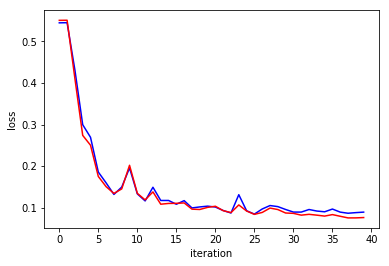

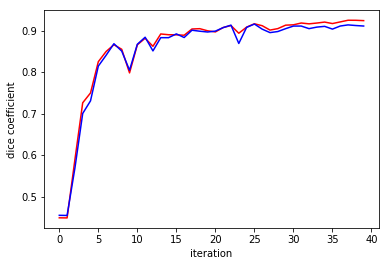

In [ ]:
plt.figure(1)
plt.plot(test_loss, 'b-')
plt.plot(train_loss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.figure(2)
plt.plot(train_dice, 'r-')
plt.plot(test_dice, 'b-')
plt.xlabel('iteration')
plt.ylabel('dice coefficient')
plt.show()

In [ ]:
test_loss_k, test_dice_k, test_jaccard_k = model.evaluate(x_test, y_test)

545/545 [==============================] - 105s 192ms/step


In [ ]:
print('test loss:', test_loss_k)
print('test jaccard:', test_jaccard_k)
print('test dice coefficient:', test_dice_k)

test loss: 0.07672981548746792
test jaccard: 0.8648405441450416
test dice coefficient: 0.9231621731311903


**Muốn lưu hoặc load 1 bộ weight vào google drive cần tạo lại một PyDrive**

In [ ]:
#tạo lại một PyDrive Client để kết nối với Google drive 
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#lưu và upload weight lên driver vừa khởi tạo
model.save_weights('cardiac_segment_sunnybrook_upgrade4_weights.h5')
weights_file = drive.CreateFile({'title' : 'cardiac_segment_sunnybrook_upgrade4_weights.h5'})
weights_file.SetContentFile('cardiac_segment_sunnybrook_upgrade4_weights.h5')
weights_file.Upload()
drive.CreateFile({'id': weights_file.get('id')})

GoogleDriveFile({'id': '1_x-4mE4DrztW0qHDSXX8Hz2RnSLxOeA_'})

In [ ]:
#load các weight trên google dive vào mô hình
#link = 'https://drive.google.com/open?id=1N5k_PjvoRzXMQwyZDr50dt9LzlFjTnMv'    #vuptran weights
link = 'https://drive.google.com/open?id=1g4xlWu5mqgMn0Bkr7Bh_o0oE2n37tRHs'    #weights 
fluff, id = link.split('=')
last_weight_file = drive.CreateFile({'id': id}) 
last_weight_file.GetContentFile('last_weights.mat')
model.load_weights('last_weights.mat')

W0625 02:15:23.126481 140572457707392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

